# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

There are many features embedded in job descriptions. Is there any association betweeen the job description and salary? If so, what are the important features? 

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
#etc

#your info here
__author__ = "Linchen Deng"
__email__ = "linchen_deng@brown.edu"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
train_X = pd.read_csv("data/train_features.csv")
train_y = pd.read_csv("data/train_salaries.csv")
test_X = pd.read_csv("data/test_features.csv")

### ---- 3 Clean the data ----

In [ ]:
# Take a look at the training data
train_X.head()

In [ ]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
print(train_X.shape)
print(train_X.info())

In [ ]:
print(train_y.shape)
print(train_y.info())

In [ ]:
# There is no NAs in the training data 
train_X.isnull().any()

In [ ]:
# There is no duplicated row in the training data
train_X[train_X.duplicated()]

In [3]:
# Check non-positive salaries
wrong_salary_rows = train_y["salary"]<=0
train_y[wrong_salary_rows]

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [4]:
# remove rows with zero salaries in the training data
train_X.drop(train_X[wrong_salary_rows].index, inplace=True)
train_y.drop(train_y[wrong_salary_rows].index, inplace=True)

### ---- 4 Explore the data (EDA) ----

In [ ]:
#summarize numeric features
train_X.describe()

In [ ]:
# Counts of levels in each categorical feature 
print(train_X.jobType.value_counts().plot())
print(train_X.degree.value_counts())
print(train_X.major.value_counts())
print(train_X.industry.value_counts())

In [ ]:
#summarize the target variable
train_y.describe()

In [5]:
# combine features and salaries for visualizations
train_combined = pd.merge(left=train_X,right=train_y, left_on='jobId', right_on='jobId')

In [ ]:
#look for correlation between each feature and the target
train_combined.dtypes

In [6]:
def barplot_categorical(data, variable_x):
    ordered_category = data.groupby(variable_x).salary.mean().sort_values(ascending=False).index
    ax = sns.barplot(x="salary",y=variable_x,data=data, order=ordered_category)
    return ordered_category

#### Job Type and Salary
On average, CEO makes more salary than CTO and CFO; Manager makes more than senior, which is more than junior; Janitor makes the least.

In [7]:
import seaborn as sns
jobType_order = barplot_categorical(train_combined, "jobType")

#### Degree and Salary
On average, phD > Masters > Bachelors > High School > None(categorized as below high school)
The salary gap between a high school and a Bachelor's degree is 4 times higher than the difference either between Bachelor's and Master's or Master's and phD.  

In [8]:
train_combined.groupby("degree").salary.mean()

degree
BACHELORS      125.454663
DOCTORAL       135.490979
HIGH_SCHOOL    101.921085
MASTERS        130.505647
NONE            98.176882
Name: salary, dtype: float64

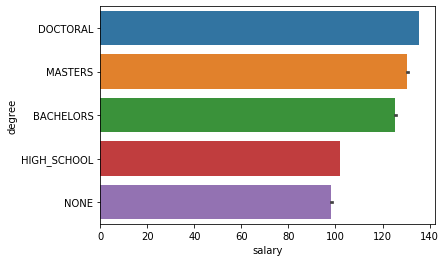

In [9]:
degree_order = barplot_categorical(train_combined, "degree")

#### major and salary
Engineering, business, math, computer science (Practical and Generally Appliable majors) have higher salaries than physics, chemistry, biology, literature (Basic sciences and Art majors). 

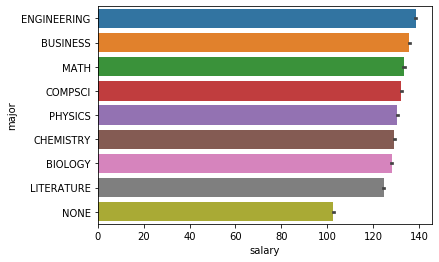

In [10]:
major_order = barplot_categorical(train_combined, "major")

#### industry and salary
Oil and finance industry have higher salary than web, health, auto industry, higher than service and education industry.

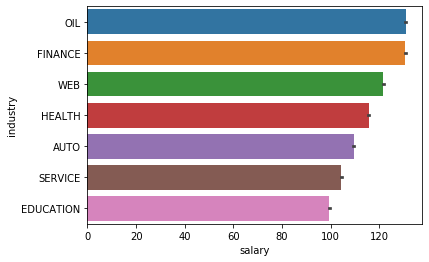

In [11]:
industry_order = barplot_categorical(train_combined, "industry")

#### Years experience and salary
On average, more years of experience is correlated with higher salary.

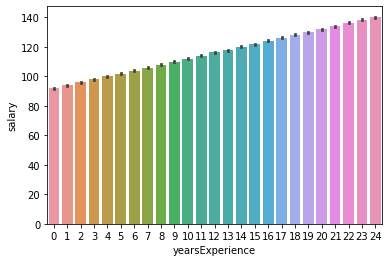

In [12]:
sns.barplot(x="yearsExperience",y="salary",data=train_combined)

#### Miles from metropolis and salary
The further the job from the metropolis, the lower the salary.

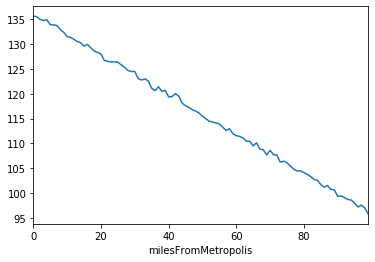

In [13]:
train_combined.groupby("milesFromMetropolis").salary.mean().plot()

### Correlation between features
Degree and major are positively correlated with correlation coefficient 0.639. 
Degree and jobType are positively correlated with correlation coefficient 0.202.
Major and jobType are positively correlated with correlation coefficient 0.167.

Salary is correlated with jobType(0.579), degree(0.384044),yearsExperience(0.375013), 	major(0.346213), industry(0.293894), milesFromMetropolis(-0.297686).

In [14]:
# Preprocessing: map categorical variables to ordinal numbers based on group average salary
replace_map = {"jobType":{x:i+1 for i,x in enumerate(jobType_order[::-1])},
              "degree":{x:i+1 for i,x in enumerate(degree_order[::-1])},
              "industry":{x:i+1 for i,x in enumerate(industry_order[::-1])},
              "major":{x:i+1 for i,x in enumerate(major_order[::-1])}}
replace_map

{'jobType': {'JANITOR': 1,
  'JUNIOR': 2,
  'SENIOR': 3,
  'MANAGER': 4,
  'VICE_PRESIDENT': 5,
  'CFO': 6,
  'CTO': 7,
  'CEO': 8},
 'degree': {'NONE': 1,
  'HIGH_SCHOOL': 2,
  'BACHELORS': 3,
  'MASTERS': 4,
  'DOCTORAL': 5},
 'industry': {'EDUCATION': 1,
  'SERVICE': 2,
  'AUTO': 3,
  'HEALTH': 4,
  'WEB': 5,
  'FINANCE': 6,
  'OIL': 7},
 'major': {'NONE': 1,
  'LITERATURE': 2,
  'BIOLOGY': 3,
  'CHEMISTRY': 4,
  'PHYSICS': 5,
  'COMPSCI': 6,
  'MATH': 7,
  'BUSINESS': 8,
  'ENGINEERING': 9}}

In [15]:
train_combined.replace(replace_map, inplace=True)

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobType,1.000000,0.201779,0.167442,0.002146,0.001061,-0.000212,0.578922
degree,0.201779,1.000000,0.638639,0.001305,0.000217,0.001785,0.384044
major,0.167442,0.638639,1.000000,-0.000168,-0.000114,0.001128,0.346213
industry,0.002146,0.001305,-0.000168,1.000000,0.000624,-0.001158,0.293894
yearsExperience,0.001061,0.000217,-0.000114,0.000624,1.000000,0.000672,0.375013
milesFromMetropolis,-0.000212,0.001785,0.001128,-0.001158,0.000672,1.000000,-0.297686
salary,0.578922,0.384044,0.346213,0.293894,0.375013,-0.297686,1.000000


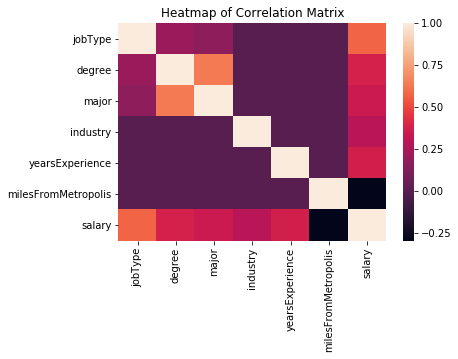

In [16]:
import matplotlib.pyplot as plt
corr = train_combined.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

### ---- 5 Establish a baseline ----

In [29]:
train_X_new = train_combined[['jobType','degree','major','industry',
                              'yearsExperience','milesFromMetropolis']]
train_y_new = train_combined['salary'].astype("float64")

#### BaseLine model: predicting salary by jobType

In [18]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation
class avg_salary_by_jobType:
    def __init__(self, data):
        self.avg_salary = data.groupby("jobType").salary.mean()
        self.rule = {i+1:x for i,x in enumerate(self.avg_salary)}
    def predict(self, test_X):
        self.prediction = test_X.jobType.map(lambda x:self.rule[x])
        return self.prediction

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=100)
MSE = 0
for train, test in kf.split(train_X_new):
    train_fold = pd.concat([train_X_new.iloc[train,:], train_y_new[train]], axis=1, ignore_index=False)
    jobType_model = avg_salary_by_jobType(train_fold)
    prediction = jobType_model.predict(train_X_new.iloc[test,:])
    diff = prediction - train_y_new[test]
    MSE += diff.pow(2).sum()/len(test)
print(MSE/5)


963.9499897952683


### ---- 6 Hypothesize solution ----

In [19]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

In [20]:
# Model 1 Linear Regression without interaction
from sklearn.linear_model import LinearRegression
MSE = 0
for train, test in kf.split(train_X_new):
    lr_model = LinearRegression()
    lr_model.fit(train_X_new.loc[train,:], train_y_new[train])
    prediction = lr_model.predict(train_X_new.loc[test,:])
    diff = prediction - train_y_new[test]
    MSE += diff.pow(2).sum()/len(test)
print(lr_model.score(train_X_new.loc[test,:], train_y_new[test]))
print(lr_model.coef_)
print(lr_model.intercept_)
print(MSE/5)


0.7356279610245862
[ 8.7233478   5.22311538  1.94488133  5.66009929  2.01073299 -0.39959442]
29.13818422622576
397.09658589745226


In [32]:
# Model 2 Linear Regression with interaction between degree, major, jobType
train_X_inter = train_X_new.copy()
train_X_inter['degreeMajor'] = train_X_inter['degree'].mul(train_X_inter['major'])
train_X_inter['jobTypeMajor'] = train_X_inter['jobType'].mul(train_X_inter['major'])
train_X_inter['degreejobType'] = train_X_inter['degree'].mul(train_X_inter['jobType'])
MSE = 0
for train, test in kf.split(train_X_inter):
    lr_model = LinearRegression()
    lr_model.fit(train_X_inter.loc[train,:], train_y_new[train])
    prediction = lr_model.predict(train_X_inter.loc[test,:])
    diff = prediction - train_y_new[test]
    MSE += diff.pow(2).sum()/len(test)
print(lr_model.score(train_X_inter.loc[test,:], train_y_new[test]))
print(lr_model.coef_)
print(lr_model.intercept_)
print(MSE/5)

0.736000463312447
[ 9.27311944  5.78443087  2.53044199  5.65979658  2.0105579  -0.39964892
 -0.03212314 -0.09627653 -0.11522138]
26.614669133739326
396.4067719855261


In [36]:
# Model 3, try using a regression tree
from sklearn.tree import DecisionTreeRegressor 
MSE = 0
for train, test in kf.split(train_X_new):
    DTR = DecisionTreeRegressor()
    DTR.fit(train_X_new.loc[train,:], train_y_new[train])
    prediction = DTR.predict(train_X_new.loc[test,:])
    diff = prediction - train_y_new[test]
    MSE += diff.pow(2).sum()/len(test)
print(MSE/5)

692.2564531287853


Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

In [38]:
# Model 4, gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
MSE = 0
i=1
for train, test in kf.split(train_X_new):
    print(i)
    i += 1
    GBR = GradientBoostingRegressor(loss="lad",learning_rate=0.1, n_estimators=100,
                                    min_samples_split=2, min_samples_leaf=1,
                                    max_depth=3, verbose=1)
    GBR.fit(train_X_new.loc[train,:], train_y_new[train])
    prediction = GBR.predict(train_X_new.loc[test,:])
    diff = prediction - train_y_new[test]
    MSE += diff.pow(2).sum()/len(test)
print(MSE/5)

1
      Iter       Train Loss   Remaining Time 
         1          29.5093            2.45m
         2          28.2206            2.43m
         3          27.1315            2.39m
         4          26.1543            2.35m
         5          25.2883            2.30m
         6          24.5016            2.28m
         7          23.8143            2.25m
         8          23.1627            2.18m
         9          22.5709            2.11m
        10          22.0335            2.08m
        20          18.6165            1.89m
        30          17.0291            1.66m
        40          16.2674            1.42m
        50          15.8906            1.18m
        60          15.7000           56.38s
        70          15.6036           42.18s
        80          15.5520           27.95s
        90          15.5194           13.93s
       100          15.4959            0.00s
2
      Iter       Train Loss   Remaining Time 
         1          29.4820            2.27m
    

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data